# Gün 4 bölüm 1: Salgın verileriyle gerçek zamanlı

<div style="background: #f8f9fa; padding: 0.5rem 1rem; border-radius: 8px; margin-bottom: 1rem; border-left: 4px solid #007bff;">
<a href="../../index.ipynb" style="text-decoration: none; color: #007bff; font-weight: bold;">← Kurs İndeksine Geri Dön</a> | 
<a href="../../index-tr.ipynb" style="text-decoration: none; color: #dc3545; font-weight: bold;">🇹🇷 Türkçe İndeks</a>
</div>

---

## Giriş

Bu uygulama (iki bölümde) bir Ebola Virüs Hastalığı (EVD) salgınının erken değerlendirmesini ve yeniden yapılandırılmasını simüle eder. Vaka ölüm oranı (CFR), epieğriler, büyüme oranı tahmini, temas izleme verileri, gecikmeler ve bulaştırıcılık tahminleri dahil olmak üzere salgının erken aşamasının analizinin çeşitli yönlerini tanıtır.

## Öğrenme çıktıları

Bu uygulamanın sonunda şunları yapabilmelisiniz:

- R'de salgın verilerini yükleme ve temizleme ([bölüm 1](./real-time-response-1.html))

- Vaka ölüm oranını (CFR) tahmin etme ([bölüm 1](./real-time-response-1.html))

- Çizgi listesinden insidans hesaplama ve çizme ([bölüm 1](./real-time-response-1.html))

- Salgının büyüme oranını ve ikiye katlanma süresini tahmin etme ve yorumlama ([bölüm 2](./real-time-response-2.html))

- Bulaştıran / bulaşan birey çiftlerine dair verilerden seri aralığı tahmin etme ([bölüm 2](./real-time-response-2.html))

- Salgının üreme sayısını tahmin etme ve yorumlama ([bölüm 2](./real-time-response-2.html))

- Kısa vadeli gelecekteki insidansı öngörme ([bölüm 2](./real-time-response-2.html))


## Batı Afrika'da kurgusal bir ülkede yeni bir EVD salgını

Batı Afrika'da kurgusal bir ülkede yeni bir EVD salgını bildirildi. Sağlık Bakanlığı salgın müdahalesini koordine etmekle görevli ve sizi gerçek zamanlı müdahaleyi bilgilendirmek için salgın analizi konusunda danışman olarak görevlendirdi.

## Gerekli paketler 

CRAN veya github'da mevcut olan aşağıdaki paketler bu analiz için gereklidir.
Gerekli paketleri şu şekilde kurun:

Paketler kurulduktan sonra yeni bir R oturumu açmanız gerekebilir. Ardından kütüphaneleri şu şekilde yükleyin:

In [ ]:
library(readxl)
library(outbreaks)
library(incidence)
library(distcrete)
library(epitrix)
library(EpiEstim)
library(projections)
library(ggplot2)
library(magrittr)
library(binom)
library(ape)
library(outbreaker2)
library(here)

Warning message:
"package 'outbreaks' was built under R version 4.3.3"
Warning message:
"package 'distcrete' was built under R version 4.3.3"
Warning message:
"package 'binom' was built under R version 4.3.3"
Warning message:
"package 'ape' was built under R version 4.3.3"
Warning message:
"package 'outbreaker2' was built under R version 4.3.3"

Attaching package: 'outbreaker2'


The following object is masked from 'package:epicontacts':

    cases_pal


here() starts at C:/Users/juano/Dropbox/Code/Git/ankara-modelling-2025-notebooks



## Erken veriler (verileri R'ye okuma)

Size aşağıdaki çizgi listesi ve temas verileri verildi:

**linelist_20140701.xlsx**: 1 Temmuz 2014'e kadar vaka bilgilerini içeren bir çizgi listesi; ve

**contact_20140701.xlsx**: 1 Temmuz 2014'e kadar vakalar arasında bildirilen temasların listesi. "infector" potansiyel enfeksiyon kaynağını, "case_id" ise temasın alıcısını belirtir.

R'ye okumak için bu dosyaları indirin ve verileri içe aktarmak için `readxl` paketindeki `read_xlsx()` fonksiyonunu kullanın. Her içe aktarma işlemi `tibble` nesnesi olarak saklanan bir veri tablosu oluşturacak.

- Birincisini `linelist`, ve  
- ikincisini `contacts` olarak adlandırın. 

Örneğin, ilk komut satırınız şöyle görünebilir:  



In [2]:
linelist <- read_excel(here("data","linelist_20140701.xlsx"), na = c("", "NA"))
contacts <- read_excel(here("data","contacts_20140701.xlsx"), na = c("", "NA"))

Buradaki verilere ve yapıya bakmak için biraz zaman ayırın.

- Veriler ve format daha önce gördüğünüz çizgi listelerine benziyor mu?
- Salgın araştırma ekibinin bir parçası olsaydınız, başka hangi bilgileri toplamak isteyebilirdiniz?

In [3]:
dim(linelist)
head(linelist)

[1] 169  11

case_id,generation,date_of_infection,date_of_onset,date_of_hospitalisation,date_of_outcome,outcome,gender,hospital,lon,lat
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
d1fafd,0,NA,2014-04-07,2014-04-17,2014-04-19,NA,f,Military Hospital,-13.21799,8.473514
53371b,1,2014-04-09,2014-04-15,2014-04-20,NA,NA,m,Connaught Hospital,-13.21491,8.464927
f5c3d8,1,2014-04-18,2014-04-21,2014-04-25,2014-04-30,Recover,f,other,-13.22804,8.483356
6c286a,2,NA,2014-04-27,2014-04-27,2014-05-07,Death,f,NA,-13.23112,8.464776
0f58c4,2,2014-04-22,2014-04-26,2014-04-29,2014-05-17,Recover,f,other,-13.21016,8.452143
49731d,0,2014-03-19,2014-04-25,2014-05-02,2014-05-07,NA,f,NA,-13.23443,8.468572


- Ayrıca rapor tarihi, yaş, hanehalkı tanımlayıcısı, meslek vb. veriler toplamak isteyebilirsiniz.

Daha ileri analizler için tüm tarihlerin `Date` nesneleri olarak doğru şekilde saklandığından emin olmanız gerektiğini unutmayın. Bunu `as.Date` fonksiyonunu kullanarak yapabilirsiniz, örneğin:

In [4]:
linelist$date_of_onset <- as.Date(linelist$date_of_onset, format = "%Y-%m-%d")

In [5]:
linelist$date_of_infection <- as.Date(linelist$date_of_infection, format = "%Y-%m-%d")
linelist$date_of_hospitalisation <- as.Date(linelist$date_of_hospitalisation, format = "%Y-%m-%d")
linelist$date_of_outcome <- as.Date(linelist$date_of_outcome, format = "%Y-%m-%d")

Biçimlendirilmiş veriler şöyle görünmelidir:

In [6]:
head(linelist)
head(contacts)

case_id,generation,date_of_infection,date_of_onset,date_of_hospitalisation,date_of_outcome,outcome,gender,hospital,lon,lat
<chr>,<dbl>,<date>,<date>,<date>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>
d1fafd,0,NA,2014-04-07,2014-04-17,2014-04-19,NA,f,Military Hospital,-13.21799,8.473514
53371b,1,2014-04-09,2014-04-15,2014-04-20,NA,NA,m,Connaught Hospital,-13.21491,8.464927
f5c3d8,1,2014-04-18,2014-04-21,2014-04-25,2014-04-30,Recover,f,other,-13.22804,8.483356
6c286a,2,NA,2014-04-27,2014-04-27,2014-05-07,Death,f,NA,-13.23112,8.464776
0f58c4,2,2014-04-22,2014-04-26,2014-04-29,2014-05-17,Recover,f,other,-13.21016,8.452143
49731d,0,2014-03-19,2014-04-25,2014-05-02,2014-05-07,NA,f,NA,-13.23443,8.468572


infector,case_id,source
<chr>,<chr>,<chr>
d1fafd,53371b,other
f5c3d8,0f58c4,other
0f58c4,881bd4,other
f5c3d8,d58402,other
20b688,d8a13d,funeral
2ae019,a3c8b8,other


## Veri temizleme ve tanımlayıcı analiz

Bu `linelist`te bulunan verilere daha yakından bakın.

- Ne fark ediyorsunuz?

In [7]:
head(linelist)
names(linelist)

case_id,generation,date_of_infection,date_of_onset,date_of_hospitalisation,date_of_outcome,outcome,gender,hospital,lon,lat
<chr>,<dbl>,<date>,<date>,<date>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>
d1fafd,0,NA,2014-04-07,2014-04-17,2014-04-19,NA,f,Military Hospital,-13.21799,8.473514
53371b,1,2014-04-09,2014-04-15,2014-04-20,NA,NA,m,Connaught Hospital,-13.21491,8.464927
f5c3d8,1,2014-04-18,2014-04-21,2014-04-25,2014-04-30,Recover,f,other,-13.22804,8.483356
6c286a,2,NA,2014-04-27,2014-04-27,2014-05-07,Death,f,NA,-13.23112,8.464776
0f58c4,2,2014-04-22,2014-04-26,2014-04-29,2014-05-17,Recover,f,other,-13.21016,8.452143
49731d,0,2014-03-19,2014-04-25,2014-05-02,2014-05-07,NA,f,NA,-13.23443,8.468572


[1] "case_id"                 "generation"             
 [3] "date_of_infection"       "date_of_onset"          
 [5] "date_of_hospitalisation" "date_of_outcome"        
 [7] "outcome"                 "gender"                 
 [9] "hospital"                "lon"                    
[11] "lat"

Eksik girişler olduğunu fark edebilirsiniz.
Analizde önemli bir adım, veri girişindeki hataları belirlemektir.
Hastane isimlerindeki hataları değerlendirmek zor olsa da, enfeksiyon tarihinin her zaman semptom başlangıcı tarihinden önce olmasını bekleriz.
  
Negatif veya 0 günlük kuluçka dönemleri olan girişleri kaldırmak için bu veri setini temizleyin.

In [8]:
## veri girişindeki hataları belirle (negatif kuluçka dönemi)
mistakes <- which(linelist$date_of_onset <= linelist$date_of_infection)
mistakes
linelist[mistakes, ]


[1]  46  63 110

case_id,generation,date_of_infection,date_of_onset,date_of_hospitalisation,date_of_outcome,outcome,gender,hospital,lon,lat
<chr>,<dbl>,<date>,<date>,<date>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>
3f1aaf,4,2014-05-18,2014-05-18,2014-05-25,2014-05-25,NA,f,Connaught Hospital,-13.24655,8.484859
ce9c02,5,2014-05-27,2014-05-27,2014-05-29,2014-06-17,Death,m,Connaught Hospital,-13.22437,8.470248
7.0000000000000004E+86,6,2014-06-10,2014-06-10,2014-06-16,2014-06-28,NA,m,Connaught Hospital,-13.26127,8.463422


In [9]:
## veri girişindeki hataları belirle (negatif kuluçka dönemi)
mistakes <- which(linelist$date_of_onset <= linelist$date_of_infection)
mistakes
linelist[mistakes, ] # negatif veya 0 kuluçka süresi olan sadece ilk birkaç girişi göster.

[1]  46  63 110

case_id,generation,date_of_infection,date_of_onset,date_of_hospitalisation,date_of_outcome,outcome,gender,hospital,lon,lat
<chr>,<dbl>,<date>,<date>,<date>,<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>
3f1aaf,4,2014-05-18,2014-05-18,2014-05-25,2014-05-25,NA,f,Connaught Hospital,-13.24655,8.484859
ce9c02,5,2014-05-27,2014-05-27,2014-05-29,2014-06-17,Death,m,Connaught Hospital,-13.22437,8.470248
7.0000000000000004E+86,6,2014-06-10,2014-06-10,2014-06-16,2014-06-28,NA,m,Connaught Hospital,-13.26127,8.463422


"Temizlenmiş" çizgi listenizi yeni bir nesne olarak kaydedin: `linelist_clean`

In [10]:
linelist_clean <- linelist[-mistakes, ]

Tam veri setiniz olsaydı kontrol etmek isteyebileceğiniz başka hangi negatif tarihler veya hatalar olabilir?

## Vaka ölüm oranının (CFR) hesaplanması

İşte sonuç durumuna göre vaka sayıları. Bundan CFR'yi nasıl hesaplarsınız? 

In [11]:
table(linelist_clean$outcome, useNA = "ifany")


  Death Recover    <NA> 
     60      43      63 

Sonucu NA olan vakalarla ne yapacağınızı düşünün?

In [ ]:
n_dead <- sum(linelist_clean$outcome %in% "Death")
n_known_outcome <- sum(linelist_clean$outcome %in% c("Death", "Recover"))
n_all <- nrow(linelist_clean)
cfr <- n_dead / n_known_outcome
cfr_wrong <- n_dead / n_all

cfr_with_CI <- binom.confint(n_dead, n_known_outcome, method = "exact")
cfr_wrong_with_CI <- binom.confint(n_dead, n_all, method = "exact")

print(cfr_with_CI)
print(cfr_wrong_with_CI)

## İnsidans eğrilerine bakış

Bilmek istediğimiz ilk soru basitçe: ne kadar kötü?. Analizin ilk adımı tanımlayıcıdır - bir salgın eğrisi veya epieğri çizmek istiyoruz. Bu, semptom başlangıcı tarihine göre zaman içindeki insidansı görselleştirir.

`incidence` paketini kullanarak, semptom başlangıcı tarihlerine dayalı olarak `linelist_clean`den günlük insidansı hesaplayın. Sonucu i_daily adlı bir nesnede saklayın; sonuç şöyle görünmelidir:

In [ ]:
i_daily <- incidence(linelist_clean$date_of_onset) # günlük insidans

plot(i_daily, border = "black")

İnsidans tarihlerinin `i_daily$dates` semptom başlangıcı tarihi hakkında veri sahibi olduğumuz son tarihte (29 Haziran 2014) durduğunu fark edebilirsiniz. Ancak çizgi listesinin yakından incelenmesi, çizgi listesindeki son tarihin (herhangi bir girişin) aslında biraz daha sonra olduğunu gösterir (1 Temmuz 2014). Bunu değiştirmek için `incidence` fonksiyonunda `last_date` argümanını kullanabilirsiniz.

<incidence object>
[166 cases from days 2014-04-07 to 2014-07-01]

$counts: matrix with 86 rows and 1 columns
$n: 166 cases in total
$dates: 86 dates marking the left-side of bins
$interval: 1 day
$timespan: 86 days
$cumulative: FALSE


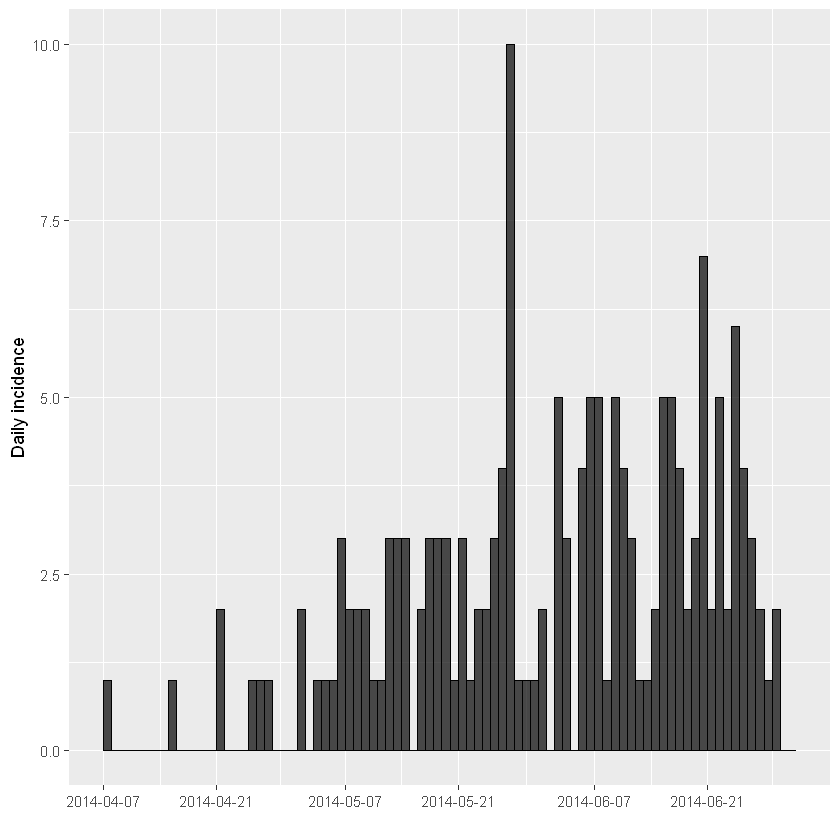

In [15]:

# son tarihi genişlet:
i_daily <- incidence(linelist_clean$date_of_onset, 
                     last_date = as.Date(max(linelist_clean$date_of_hospitalisation, na.rm = TRUE)))
i_daily
plot(i_daily, border = "black")


Başka bir sorun da günlük insidansa bakarken trendleri yorumlamanın zor olabilmesi, bu nedenle haftalık insidansı `i_weekly`'yi de şu şekilde hesaplayın ve çizin:

<incidence object>
[166 cases from days 2014-04-07 to 2014-06-30]
[166 cases from ISO weeks 2014-W15 to 2014-W27]

$counts: matrix with 13 rows and 1 columns
$n: 166 cases in total
$dates: 13 dates marking the left-side of bins
$interval: 7 days
$timespan: 85 days
$cumulative: FALSE


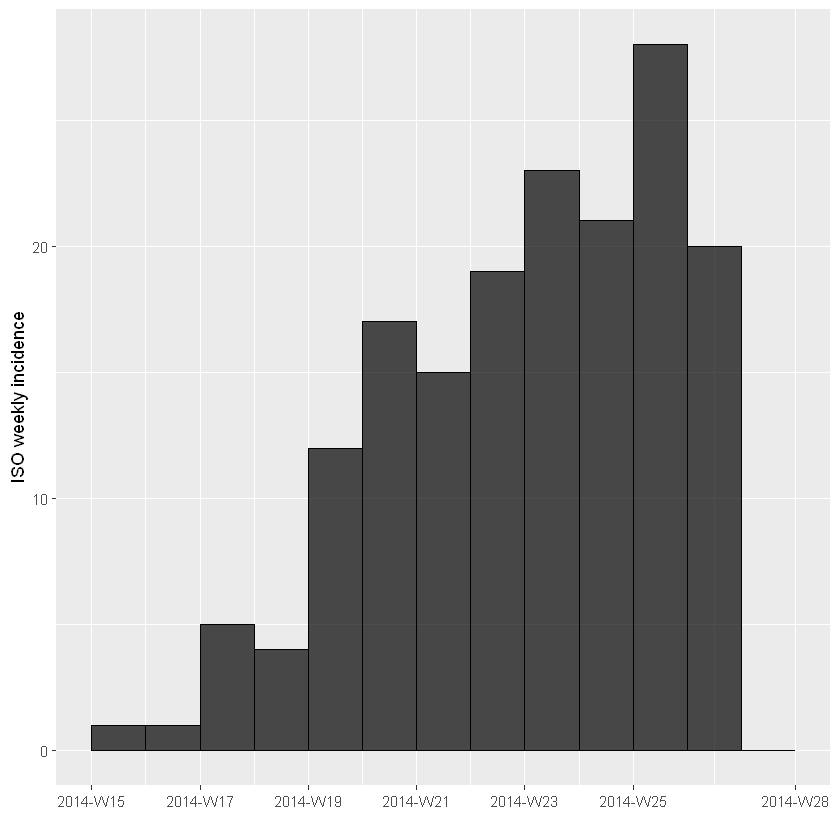

In [16]:
i_weekly <- incidence(linelist_clean$date_of_onset, interval = 7, 
                      last_date = as.Date(max(linelist_clean$date_of_hospitalisation, na.rm = TRUE)))
i_weekly

plot(i_weekly, border = "black")

## Veri ve çıktıları kaydetme

Bu uygulamanın [bölüm 1](./real-time-response-1.html)'inin sonudur. 
[Bölüm 2](./real-time-response-2.html)'ye geçmeden önce, aşağıdaki nesneleri kaydetmeniz gerekecek:

In [17]:
dir.create(here("data/clean")) # yoksa temiz veri dizini oluştur
saveRDS(i_daily, here("data/clean/i_daily.rds"))
saveRDS(i_weekly, here("data/clean/i_weekly.rds"))
saveRDS(linelist, here("data/clean/linelist.rds"))
saveRDS(linelist_clean, here("data/clean/linelist_clean.rds"))
saveRDS(contacts, here("data/clean/contacts.rds"))

Warning message in dir.create(here("data/clean")):
"'C:\Users\juano\Dropbox\Code\Git\ankara-modelling-2025-notebooks\data\clean' already exists"
